## ВКР: анализ данных

Автоматизация подбора персонала

Копчев Владислав, БПМИ197

В данном ноутбуке предобработанные в ноутбуке `preprocessing.ipynb` данные мы будем анализировать и делать из них полезные для принятия HR-решений выводы.

### Библиотеки

Импорт библиотек:

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
# !pip install transliterate
from transliterate import translit
import re
import numpy as np

from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

Мы имеем таблицу с данными, в которых все признаки приведены к простому виду, выделены новые полезные признаки, была произведена суммаризация раздела "О себе". Теперь мы произведем токенизацию раздела "О себе" на совокупность 3-грамм, которые мы и будем считать токенами, после чего построим эмбеддинги.

**Токенизация раздела "О себе" на 1-граммы:**

In [2]:
df = pd.read_csv('resumes_features.csv')

In [3]:
df.drop(list(df)[0], axis=1, inplace=True)
df.reset_index(inplace=True)
df.drop(list(df)[0], axis=1, inplace=True)

In [4]:
df.sample(1)

,Ссылка,Название,Коммандировка,Опыт,О себе,Образование,Интересы,Навыки,Образование-1,Образование-2,...,93,94,95,96,97,98,99,clust,"DA, predicted","DS, predicted"
1420,https://hh.ru/resume/428aeaaf00028c3d4d0039ed1...,Руководитель отдела продаж,"Москва, м. Молодежная, готов к переезду (Санкт...",Опыт работы 10 лет 1 месяц,"Горные лыжи, путешествия. Амбициозность, лидер...",Высшее образование\n1994\nМосковский государст...,Специализации:\nРуководитель отдела продаж\nЗа...,---,Московский государственный открытый университе...,NaN,...,0.000282,-0.000709,0.001928,-0.003363,0.002293,-0.000617,-0.003414,1,0.0,0.0


Для начала построим разбиение на 1-граммы (в коде также мы уберем пробелы и ненужные символы, стоп-слова, приведем слова к нормальной форме):

In [125]:
import nltk
# nltk.download('stopwords')

import re
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
patterns = "[0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()
def lemmatize(doc):
    # print(doc)
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stopwords_ru and morph.normal_forms(token)[0] not in stopwords_ru:  # ВОТ откуда там стоп-слвоа — В not in stopwords_ru -> normal(В) = в
            # print(token)
            token = token.strip()
            token = morph.normal_forms(token)[0]
            tokens.append(token)
    if len(tokens) > 2:
        return tokens
    return None

df2 = pd.DataFrame(df['О себе, summarized'])

for col_ind in df2.index:
    col = df2.loc[col_ind]['О себе, summarized']
    if col:
        df2.loc[col_ind]['О себе, summarized'] = lemmatize(str(col))
        #print(lemmatize(str(col)))
        
data = df2['О себе, summarized']

from collections import defaultdict
word_freq = defaultdict(int)
for tokens in data.iloc[:]:
    if tokens:
        for token in tokens:
            word_freq[token] += 1

Видим, что разбиение прошло успещно:

In [126]:
df2.sample(3)

,"О себе, summarized"
2523,"[трудолюбивый, трудолюбивый, легко, обучать, с..."
1893,"[постоянно, активно, развиваться, интернет, ма..."
2618,None


Теперь построим 2-граммы по 1-граммам:

In [127]:
from nltk.util import ngrams
from nltk import word_tokenize 

tokens2 = []

for x in df2['О себе, summarized']:
    if x is not None:
        bigrams = []
        for bg in list(ngrams(x, 2)):
            bigrams.append(' '.join(bg))
        tokens2.append(bigrams)
    else:
        tokens2.append(None)
        
df2['О себе 2'] = tokens2

In [128]:
df2.sample(3)

,"О себе, summarized",О себе 2
853,"[уверенный, черта, характер, стрессоустойчивос...","[уверенный черта, черта характер, характер стр..."
54,"[английский, язык, –, upper, intermediate, про...","[английский язык, язык –, – upper, upper inter..."
2565,"[форвард, сборная, россия, хоккей, евгений, ма...","[форвард сборная, сборная россия, россия хокке..."


Аналогичным образом, наконец, построим 3-граммы:

In [129]:
from nltk.util import ngrams
from nltk import word_tokenize 

tokens3 = []

for x in df2['О себе, summarized']:
    if x is not None:
        trigrams = []
        for tg in list(ngrams(x, 3)):
            trigrams.append(' '.join(tg))
        tokens3.append(trigrams)
    else:
        tokens3.append(None)
        
df2['О себе 3'] = tokens3

In [130]:
df2.sample(3)

,"О себе, summarized",О себе 2,О себе 3
640,"[germany, россия, сша, канада, австралия, арге...","[germany россия, россия сша, сша канада, канад...","[germany россия сша, россия сша канада, сша ка..."
152,None,None,None
806,"[обладать, доминировать, эмпатия, целеустремлё...","[обладать доминировать, доминировать эмпатия, ...","[обладать доминировать эмпатия, доминировать э..."


**Построение эмбеддингов**

Теперь перейдем к построению эмбеддингов. Будем использовать метод построения эмбеддингов word2vec. Определим векторное представление триграммы как среднее векторных представлений слов внутри нее.

In [131]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

Избавимся от пропусков, чтобы не было проблем с применением метода:

In [132]:
df2.loc[df2['О себе 3'].isna(), 'О себе 3'] = '-'

In [133]:
df2[df2['О себе 3'].isna()]['О себе 3']

Series([], Name: О себе 3, dtype: object)

Обучим модель:

In [134]:
model = Word2Vec(sentences=df2['О себе 3'], vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

In [135]:
model = Word2Vec.load("word2vec.model")

In [136]:
model.train(df2['О себе 3'], total_examples=len(df2['О себе 3']), epochs=1)

(41868, 42180)

Посмотрим, что получилось, на примере:

In [142]:
vector = model.wv['нестандартный подход решение']  # get numpy vector of a word
sims = model.wv.most_similar('нестандартный подход решение', topn=10)  # get other similar words

In [19]:
vector

array([ 2.2067500e-03, -7.3231361e-03,  7.8011141e-03,  7.6452661e-03,
        2.4990677e-03, -6.3624647e-03, -5.9403661e-05,  3.4782612e-03,
       -5.6626188e-04,  5.9506493e-03, -3.4510384e-03,  4.3406021e-03,
       -3.4173462e-03,  4.9557914e-03,  7.2136098e-03, -7.3125749e-03,
       -6.6994298e-03,  9.5764669e-03,  2.1601473e-03, -6.2942142e-03,
       -1.8191544e-03, -3.3437440e-03,  6.3336780e-04,  2.4854629e-03,
        6.5179047e-04, -2.0766382e-03,  1.5287504e-03,  7.1112881e-03,
        7.1763177e-03, -2.8673734e-03, -9.1822697e-03,  6.9630803e-03,
        2.2413163e-03,  2.8338658e-03,  3.1316516e-03,  6.2846639e-03,
       -7.1329245e-04,  4.0908363e-03, -7.2425319e-05, -9.3654795e-03,
       -2.0878434e-03, -7.2188018e-04, -7.2491588e-04,  5.9062704e-03,
       -7.4123605e-03,  9.8371506e-03, -5.1827966e-03,  2.8906062e-03,
        4.1390378e-03,  7.8106583e-03, -1.1367421e-03, -5.6662778e-03,
        9.1947811e-03, -7.3702243e-04, -5.4288865e-03,  2.2407942e-03,
      

In [143]:
sims

[('ум способность работать', 0.42437753081321716),
 ('крупный российский агентство', 0.41329023241996765),
 ('подготовка рисовый руководство', 0.38147082924842834),
 ('письменный речь быстрый', 0.3720853924751282),
 ('человек направление проектирование', 0.3675800859928131),
 ('опыт управление опыт', 0.3589397966861725),
 ('строить bi дашборд', 0.34726792573928833),
 ('эффективный проектный группа', 0.3456355929374695),
 ('футбольный болельщик готовиться', 0.3422141373157501),
 ('дважды выигрывать золото', 0.34142419695854187)]

Вектор построен корректно, похожие триграммы подобраны неплохо с точки зрения соответствия смыслу.

Итак, мы построили эмбеддинги. Теперь создадим табличку, где каждому резюме будет соответстовать вектор из 100 координат входящих в раздел "О себе" триграмм.

In [148]:
our_data = pd.DataFrame(df2['О себе 3'])
our_data['emb'] = 0
embs = []
for x in our_data['О себе 3']:
    cur_embs = []
    for y in x:
        cur_embs.append(model.wv[y])
    embs.append(cur_embs)
our_data['emb'] = embs

embs_flattened = []
for x in our_data['emb']:
    x_flat = np.array(x[0])
    for z in x[1:]:
        x_flat += np.array(z)
    embs_flattened.append(x_flat / len(x))
our_data['flat_emb'] = embs_flattened

Посмотрим, получилось ли:

In [150]:
our_data['flat_emb'][0]

array([-7.99836344e-05, -1.50046463e-03, -4.35551920e-04, -1.50737166e-03,
        1.87101890e-04, -6.84491824e-04, -1.10338395e-03,  2.63537018e-04,
        9.67469008e-04,  8.15248408e-04, -4.59374889e-04,  1.31592283e-03,
        2.90577824e-04,  5.82164037e-04, -1.85195502e-04, -3.72505398e-04,
       -9.81115038e-04, -8.18226545e-04,  8.66354312e-05,  3.16900783e-04,
        1.21780892e-03, -1.17878360e-03, -4.52461682e-05, -2.16449465e-04,
        2.96607963e-04, -2.84905545e-04, -4.40094824e-04, -6.48278743e-04,
       -2.86327646e-04,  1.69932446e-03,  4.80593997e-04, -1.15398632e-03,
        8.43726564e-04, -1.05837127e-03,  4.97588073e-04,  4.34242276e-04,
        2.84139242e-04, -5.80462860e-04, -1.16366755e-04, -1.56020408e-03,
       -2.40851557e-04, -7.77751848e-04, -7.10505934e-04,  2.73809914e-04,
        5.04683412e-04, -1.38456665e-03,  1.26650848e-03,  9.75667150e-04,
       -6.85438747e-04,  1.60656040e-04, -1.13937957e-03,  3.06473696e-04,
       -4.63332981e-07, -

Действительно, получился вектор из $\mathbb{R}^{100}$, где $i$-я координата — среднее эмбеддингов входящих в $i$-ю триграмму слов.

Уберем пропуски и запишем в `X` наши векторы:

In [213]:
our_data['flat_emb'].dropna()
X = list(our_data['flat_emb'].dropna())
X = np.asarray(X)
X

array([[-7.9983634e-05, -1.5004646e-03, -4.3555192e-04, ...,
        -4.4411735e-04,  7.6554163e-04,  8.0740218e-05],
       [ 6.5256917e-04, -1.3126576e-03, -7.2877301e-05, ...,
        -2.4316886e-04, -3.1289060e-03,  1.4584048e-03],
       [-1.3510333e-04,  8.5367518e-04,  2.2937981e-03, ...,
        -2.7531173e-04, -3.1162152e-04, -4.3715845e-04],
       ...,
       [ 2.5283226e-03,  2.1679702e-03,  4.1107135e-03, ...,
         2.6390133e-03, -1.6444033e-03, -3.4496421e-05],
       [-5.3622725e-04,  2.3643016e-04,  5.1033497e-03, ...,
        -7.0415614e-03,  9.0145587e-04,  6.3925339e-03],
       [-5.3622725e-04,  2.3643016e-04,  5.1033497e-03, ...,
        -7.0415614e-03,  9.0145587e-04,  6.3925339e-03]], dtype=float32)

Осталось проверить, правда ли имеющие близкое к 0 [cosine distance](https://medium.com/geekculture/cosine-similarity-and-cosine-distance-48eed889a5c4) векторы похожи, а близкое к 1 — различны.

Пример ортогональных векторов:

In [82]:
df['О себе, summarized'][0]

'Уверенный пользователь ПК, Ms Word, Ms Excel, 1С, Power Point, Internet Explorer, amoCRM, Bitrix24 и офисной техники; Правовых систем Гарант и Консультант +; Знание законодательства; Работа с входящей и исходящей корреспонденцией, Этика делового общения, общения с клиентами; Навыки работы по взаимодействию с государственными органами и общественными организациями; Неоднократное участие в судебных заседаниях; Анализ данных, составление договоров, запросов, отзывов, заявлений, уведомлений.'

In [83]:
df['О себе, summarized'][1]

'В настоящее время занимаюсь благотворительной деятельностью. В свободное время занимаюсь бегом, плаванием, рисую в стиле фантази (карандаш), много путешествую, интересуюсь различиями культур и обычаями народов мира.'

In [119]:
distance.cosine(X[0], X[1])

0.9508250653743744

Действительно, мы вижим, что резбме различны.

Пример коллинеарных:

In [87]:
df['О себе, summarized'][14]

'Нахожусь в отпуске по уходу за ребенком. На данный момент у меня нет официального места работы.'

In [88]:
df['О себе, summarized'][84]

'Нахожусь в отпуске по уходу за ребенком. На данный момент у меня нет вакантных должностей.'

In [118]:
distance.cosine(X[14], X[84])

0.30464255809783936

Видно, что резюме похожи. 

Осталось записать эти векторы в 100 столбцов нашей таблицы:

In [234]:
for col in list(pd.DataFrame(X)):
    df[str(col)] = pd.DataFrame(X)[col]

In [237]:
df.sample(2)

,Ссылка,Название,Коммандировка,Опыт,О себе,Образование,Интересы,Навыки,Образование-1,Образование-2,...,90,91,92,93,94,95,96,97,98,99
121,https://hh.ru/resume/043d1db90003ba62800039ed1...,Менеджер / руководитель банка по работе с корп...,"Москва, готова к переезду, готова к командировкам",Опыт работы 23 года 4 месяца,Достижения:\nВ роли клиентского менеджера неод...,Высшее образование\n2000\nВоронежский государс...,Специализации:\nМенеджер/консультант по страте...,Проектное управление\nРабота в команде\nОргани...,Воронежский государственный аграрный университ...,Воронежский государственный аграрный университ...,...,0.000286,0.000614,0.001554,-0.002824,0.000827,0.000280,0.001855,-0.001364,-0.001045,-0.001283
1637,https://hh.ru/resume/14e87dbf0000728a8a0039ed1...,эксперт по бизнес-процессам (управленческий/ин...,"Москва, не готов к переезду, не готов к команд...",Опыт работы 19 лет 10 месяцев,"Компетенции, навыки, знания, умения:\n• Владен...",Высшее образование\n2002\nМИРЭА\nавтоматизиров...,Специализации:\nРуководитель группы разработки...,---,МИРЭА,NaN,...,0.000520,0.001356,-0.001179,-0.000428,-0.000851,-0.000229,0.003184,0.001581,0.000368,-0.000344


Сохраним то, что получилось:

In [ ]:
df.to_csv('resumes_features.csv')

**Трансформация признаков**

Мы будем обучаться не на всех признаках, а только на специально отобранных. А именно:
- Кол-во образований
- Опыт нормализованный
- Топовость образования
- Справочник по интересам
- Релокация?
- Коммандировка?
- Город?
- Уровень оборазования нормализованный
- Карьерный рост
- Аналитические комбинации слов в навыках
- 100 word2vec-векторов входящих в "О себе" триграмм

Обработаем числовые признаки:

In [58]:
txts = []
for i in range(df.shape[0]):
    txt = df.loc[i, 'Опыт нормализованный']
    # print(txt)
    if re.search('[а-яА-Я]', txt):
        txt = -1
    elif txt[-1] == ';':
        txt = int(txt[:txt.find(';')])
    else:
        txt = int(txt[:txt.find(';')]) + int(txt[txt.find(';')+1:]) / 12
    txts.append(txt)
df.loc[:, 'Опыт нормализованный'] = txts

Обработаем категориальные (нам подойдет именно `LabelEncoder`, так как, к примеру, высшее образование лучше среднего, наличие аналитических комбинаций лучше отсутствия, проживание в Москве предпочтительнее для компании, чем необходимость релокации в Москву):

In [70]:
categorial = ['Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']
le = LabelEncoder()
for col in categorial:
    df[col] = le.fit_transform(df[col])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(col, ":", le_name_mapping)
df

Топовость образования : {False: 0, True: 1}
Справочник по интересам : {'---': 0, 'found smt by rule (Analyst)|(Аналитик данных)|(аналитик)|(Аналитик)': 1}
Релокация? : {' готов к командировкам': 0, ' готов к редким командировкам': 1, ' готова к командировкам': 2, ' готова к редким командировкам': 3, ' не готов к командировкам': 4, ' не готова к командировкам': 5}
Коммандировка? : {' готов к переезду': 0, ' готова к переезду': 1, ' не готов к переезду': 2, ' не готова к переезду': 3}
Город? : {'Альметьевск': 0, 'Армавир': 1, 'Астрахань': 2, 'Ахтубинск': 3, 'Балаково': 4, 'Балашиха': 5, 'Белгород': 6, 'Брянск': 7, 'Валуйки': 8, 'Владивосток': 9, 'Владимир': 10, 'Волгоград': 11, 'Воронеж': 12, 'Выкса': 13, 'Гатчина': 14, 'Долгопрудный': 15, 'Домодедово': 16, 'Донецк': 17, 'Егорьевск': 18, 'Екатеринбург': 19, 'Ессентуки': 20, 'Железнодорожный': 21, 'Зеленоград': 22, 'Иркутск': 23, 'Казань': 24, 'Калининград': 25, 'Калуга': 26, 'Кемерово': 27, 'Коломна': 28, 'Королев': 29, 'Кострома': 30, '

,Ссылка,Название,Коммандировка,Опыт,О себе,Образование,Интересы,Навыки,Образование-1,Образование-2,...,91,92,93,94,95,96,97,98,99,clust
0,https://hh.ru/resume/a179dc8e00074bc7400039ed1...,Администратор салона красоты,"Москва, м. Молодежная, не готова к переезду, г...",Опыт работы 7 лет 1 месяц,"Уверенный пользователь ПК, Ms Word, Ms Excel, ...",Высшее образование\n2015\nФГБУ ВПО «Российский...,Специализации:\nАдминистратор\nЗанятость: полн...,Коммуникации с клиентами и партнерами/Работа с...,ФГБУ ВПО «Российский экономический университет...,ФГБУ ВПО «Саратовская Государственная Юридичес...,...,0.000352,0.001681,-0.000292,-0.000272,-1.206897e-03,0.000227,-0.000444,0.000766,0.000081,0
1,https://hh.ru/resume/cdaf5cfe00003bcc320039ed1...,Руководитель отдела планирования и управления ...,"Москва, м. Выхино, готова к переезду, готова к...",Опыт работы 17 лет 3 месяца,"Энергична, активна, в поиске новых возможносте...",Высшее образование\n2010\nМосковский Государст...,Специализации:\nНачальник склада\nЗанятость: п...,---,Московский Государственный Университет Экономи...,NaN,...,-0.000102,0.000081,0.000894,-0.002202,1.397842e-03,-0.001827,-0.000243,-0.003129,0.001458,0
2,https://hh.ru/resume/fb6ac9c200027770d60039ed1...,Начальник отдела продаж,"Шахты, готова к переезду (Москва, Санкт-Петерб...",Опыт работы 18 лет 4 месяца,"опыт прямых продаж, ведение коммерческих перег...",Высшее образование\n2001\nЮжно-Российский госу...,Специализации:\nРуководитель отдела продаж\nЗа...,---,Южно-Российский государственный университет эк...,NaN,...,-0.000671,-0.000236,0.000330,0.001575,2.981558e-04,0.002110,-0.000275,-0.000312,-0.000437,0
3,https://hh.ru/resume/e23c95770000b1b95f0039ed1...,"Коммерческий директор, Финансовый директор","Москва, м. Бабушкинская, готов к переезду, гот...",Опыт работы 17 лет 5 месяцев,Коммуникабелен\nУмение работать с возражениями...,Высшее образование\n2006\nБрянский государстве...,Специализации:\nКоммерческий директор (CCO)\nФ...,---,Брянский государственный технический университет,Брянский государственный технический университет,...,0.002909,0.000544,0.001400,0.002620,6.619219e-04,0.001653,-0.000912,-0.000753,0.000754,0
4,https://hh.ru/resume/9c86655b00073d88700039ed1...,QA/auto QA/Performance QA,"Краснодар, готов к переезду (Москва, Санкт-Пет...",Опыт работы 7 лет 10 месяцев,Дисциплина - умение выполнять поставленные зад...,Среднее специальное образование\n2009\nКраснод...,Специализации:\nТестировщик\nЗанятость: стажир...,---,Краснодарский Государственный Гуманитарно Техн...,NaN,...,-0.000626,0.002497,-0.002705,0.000145,-1.641789e-07,0.005385,0.000633,-0.000351,-0.003165,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2720,https://hh.ru/resume/b74645f3000102b1b90039ed1...,Финансовый аналитик,"Москва, м. Крылатское, не готова к переезду, н...",Опыт работы 8 лет 11 месяцев,"Уверенный пользователь ПК: MS Office (Word, Ex...",Высшее образование\n2009\nЧувашский государств...,"Специализации:\nФинансовый аналитик, инвестици...",---,Чувашский государственный университет имени И....,NaN,...,0.000045,-0.002575,0.001634,-0.003021,-5.501702e-03,0.002582,-0.000392,0.005978,-0.003172,0
2721,https://hh.ru/resume/0ed518390003eb7c860039ed1...,Аналитик,"Москва, м. Ховрино, не готов к переезду, готов...",Опыт работы 3 года 4 месяца,Моя потребность в постоянном улучшении себя на...,Неоконченное высшее образование\n2019\nЮжный ф...,Специализации:\nАналитик\nЗанятость: частичная...,Другое\nДеловая коммуникация\nАдминистративное...,"Южный федеральный университет, Ростов-на-Дону",NaN,...,0.003901,0.001973,-0.003310,0.011862,2.661309e-03,0.006801,-0.001823,-0.000610,-0.008534,3
2722,https://hh.ru/resume/16deef470000020e170039ed1...,Finance Controller,"Москва, м. Коммунарка, не готова к переезду, г...",Опыт работы 19 лет 1 месяц,.,Высшее образование\n1999\nSaratov State Techni...,Специализации:\nФинансовый контролер\nФинансов...,---,Saratov State Technical University,NaN,...,0.001383,-0.001468,-0.00312

Вот как теперь выглядит наша таблица:

In [75]:
df.loc[:, ['Кол-во образований', 'Опыт нормализованный', 'Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках'] + list(df)[36:]]

,Кол-во образований,Опыт нормализованный,Топовость образования,Справочник по интересам,Релокация?,Коммандировка?,Город?,Уровень оборазования нормализованный,Карьерный рост,Аналитические комбинации слов в навыках,...,91,92,93,94,95,96,97,98,99,clust
0,2,7.083333,0,0,3,3,39,1,0,1,...,0.000352,0.001681,-0.000292,-0.000272,-1.206897e-03,0.000227,-0.000444,0.000766,0.000081,0
1,1,17.250000,0,0,2,1,39,1,0,0,...,-0.000102,0.000081,0.000894,-0.002202,1.397842e-03,-0.001827,-0.000243,-0.003129,0.001458,0
2,1,18.333333,0,0,2,1,91,1,0,0,...,-0.000671,-0.000236,0.000330,0.001575,2.981558e-04,0.002110,-0.000275,-0.000312,-0.000437,0
3,2,17.416667,0,0,0,0,39,1,1,0,...,0.002909,0.000544,0.001400,0.002620,6.619219e-04,0.001653,-0.000912,-0.000753,0.000754,0
4,1,7.833333,0,0,0,0,32,8,1,0,...,-0.000626,0.002497,-0.002705,0.000145,-1.641789e-07,0.005385,0.000633,-0.000351,-0.003165,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2720,1,8.916667,0,1,5,3,39,1,1,0,...,0.000045,-0.002575,0.001634,-0.003021,-5.501702e-03,0.002582,-0.000392,0.005978,-0.003172,0
2721,1,3.333333,0,1,0,2,39,5,1,0,...,0.003901,0.001973,-0.003310,0.011862,2.661309e-03,0.006801,-0.001823,-0.000610,-0.008534,3
2722,1,19.083333,0,0,2,3,39,1,1,0,...,0.001383,-0.001468,-0.003124,0.002176,-7.177151e-04,-0.001517,0.002639,-0.001644,-0.000034,0
2723,2,12.416667,0,0,0,0,39,1,0,0,...,0.000190,0.003474,0.000218,0.009619,5.060604e-03,-0.008917,-0.007042,0.000901,0.006393,2


Сохраним то, что получилось:

In [76]:
df.to_csv('resumes_features.csv')

**Разметка данных 2**

В ноутбуке `preprocessing.ipynb` было размечено ~100 резюме. Но для хорошей работы моделей нужно больше — разметим еще ~170 резюме, чтобы размечено было около 10% всех резюме в нашей выборке.

In [776]:
# count = 0

In [1039]:
print('Осталось разметить:', 170 - count)

Осталось разметить: -18


In [1040]:
df_sample = df.sample(1).loc[:, ['Ссылка', 'Название', 'DA', 'DS']]
print(df_sample['Ссылка'].iloc[0])
print(df_sample['Название'].iloc[0])

https://hh.ru/resume/16177621000303e1b60039ed1f3043514a3878?query=%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D1%82%D0%B8%D0%BA+%D0%BF%D1%80%D0%BE%D0%B4%D0%B0%D0%B6&source=search&hhtmFrom=resumes_catalog
Руководитель подразделения продаж


In [1041]:
df.loc[df_sample.index[0], ['Название', 'DA', 'DS']]

Название    Руководитель подразделения продаж
DA                                        NaN
DS                                        NaN
Name: 2012, dtype: object

In [1042]:
df.loc[df_sample.index[0], 'DA'] = 0
df.loc[df_sample.index[0], 'DS'] = 0

In [1043]:
count += 1

In [1231]:
df.to_csv('resumes_features.csv')

**Классификация**

Наконец, перейдем к построению скоринговой модели (решим задачу классификации):

In [40]:
df = pd.read_csv('resumes_features.csv')

In [41]:
df.drop(list(df)[0], axis=1, inplace=True)
df.reset_index(inplace=True)
df.drop(list(df)[0], axis=1, inplace=True)

In [77]:
df.sample(1)

,Ссылка,Название,Коммандировка,Опыт,О себе,Образование,Интересы,Навыки,Образование-1,Образование-2,...,91,92,93,94,95,96,97,98,99,clust
1954,https://hh.ru/resume/1659bb97000275c95a0039ed1...,Заместитель финансового директора/Главный бухг...,"Москва, м. Митино, не готов к переезду, готов ...",Опыт работы 17 лет 2 месяца,"Личные качества: организованность, ответственн...",Высшее образование\n2007\nРоссийский государст...,Специализации:\nФинансовый менеджер\nЗанятость...,---,Российский государственный торгово-экономическ...,Российский государственный торгово-экономическ...,...,-0.002755,-0.00086,-0.002799,0.000144,-0.000626,-0.003615,0.003815,-0.000457,-0.001887,0


Для [оценки качества](https://stats.stackexchange.com/questions/12702/what-are-the-measure-for-accuracy-of-multilabel-data) по $F_1$-мере заведем специальный словарь:

In [1394]:
from sklearn.metrics import f1_score

In [1395]:
lr_svm_rf_dict = {
                    'not semi-supervised': [66, 73, 72], 
                    'semi-supervised': [70, 72, 70]
                }

Начнем с логистической регрессии (она [подходит](https://scikit-learn.org/stable/modules/multiclass.html#multilabel-classification-format) для мульти-классовой классификации):

In [1396]:
acc = 0.
k = 10
reg = LogisticRegression(max_iter=10000)
self_training_model = SelfTrainingClassifier(reg)

for i in range(k):
    X = df.loc[df['DA'] != -1].loc[:, list(df)[36:] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
    y = df.loc[df['DA'] != -1, 'DA']
    
    X_train = X.sample(200)
    y_train = y[X_train.index]
    
    X_test = X.drop(X_train.index)
    y_test = y.drop(y_train.index)
    
    reg.fit(X_train, y_train)
    acc += f1_score(y_test, reg.predict(X_test), average='micro')

In [1397]:
lr_svm_rf_dict['not semi-supervised'][0] = acc / k

In [1398]:
pd.DataFrame(reg.predict(X_test)).value_counts()

0.0    73
2.0     3
1.0     2
dtype: int64

Теперь попробуем SVM:

In [1399]:
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

In [1400]:
acc = 0.
k = 20
clf = DecisionTreeClassifier()
self_training_model = SelfTrainingClassifier(clf)

for i in range(k):
    X = df.loc[df['DA'] != -1].loc[:, list(df)[36:] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
    y = df.loc[df['DA'] != -1, 'DA']
    
    X_train = X.sample(200)
    y_train = y[X_train.index]
    
    X_test = X.drop(X_train.index)
    y_test = y.drop(y_train.index)
    
    clf.fit(X_train, y_train)
    acc += f1_score(y_test, clf.predict(X_test), average='micro')

In [1401]:
lr_svm_rf_dict['not semi-supervised'][1] = acc / k

In [1402]:
pd.DataFrame(clf.predict(X_test)).value_counts()

0.0    68
1.0     8
2.0     2
dtype: int64

И, наконец, RF:

In [1403]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [1404]:
acc = 0.
k = 10
clf = KNeighborsClassifier()
self_training_model = SelfTrainingClassifier(clf)

for i in range(k):
    X = df.loc[df['DA'] != -1].loc[:, list(df)[36:] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
    y = df.loc[df['DA'] != -1, 'DA']
    
    X_train = X.sample(200)
    y_train = y[X_train.index]
    
    X_test = X.drop(X_train.index)
    y_test = y.drop(y_train.index)
    
    clf.fit(X_train, y_train)
    acc += f1_score(y_test, clf.predict(X_test), average='micro')

In [1405]:
lr_svm_rf_dict['not semi-supervised'][2] = acc / k

In [1406]:
pd.DataFrame(clf.predict(X_test)).value_counts()

0.0    75
1.0     3
dtype: int64

Теперь попробуем [semi-supervised](https://medium.datadriveninvestor.com/the-ultimate-advanced-guide-of-semi-supervised-learning-3f772ed20927) версию SVC:

In [1407]:
from sklearn.semi_supervised import SelfTrainingClassifier

Для этого `np.nan` заменим на `-1`:

In [1408]:
df.loc[~df['DA'].notna(), 'DA'] = -1

In [1409]:
acc = 0.
k = 10
svc = DecisionTreeClassifier()
self_training_model = SelfTrainingClassifier(svc)

for i in range(k):
    X = df.loc[df['DA'] != -1].loc[:, list(df)[36:] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
    y = df.loc[df['DA'] != -1, 'DA']
    X_2 = df.loc[:, list(df)[36:] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
    y_2 = df.loc[:, 'DA']
    
    X_train = X.sample(200)
    y_train = y[X_train.index]
    
    X_test = X.drop(X_train.index)
    y_test = y.drop(y_train.index)
    
    X_train = X_2.drop(X_test.index)
    y_train = y_2.drop(y_test.index)
    
    X_2.drop(X_test.index, inplace=True)
    y_2.drop(y_test.index, inplace=True)
    
    self_training_model.fit(X_2, y_2)
    acc += f1_score(y_test, self_training_model.predict(X_test), average='micro')

In [1410]:
lr_svm_rf_dict['semi-supervised'][1] = acc / k

In [1411]:
pd.DataFrame(self_training_model.predict(X_test)).value_counts()

0.0    66
1.0     9
2.0     3
dtype: int64

Теперь RF:

In [1412]:
acc = 0.
k = 10
clf = KNeighborsClassifier()
self_training_model = SelfTrainingClassifier(clf)

for i in range(k):
    X = df.loc[df['DA'] != -1].loc[:, list(df)[36:] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
    y = df.loc[df['DA'] != -1, 'DA']
    X_2 = df.loc[:, list(df)[36:] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
    y_2 = df.loc[:, 'DA']
    
    X_train = X.sample(200)
    y_train = y[X_train.index]
    
    X_test = X.drop(X_train.index)
    y_test = y.drop(y_train.index)
    
    X_train = X_2.drop(X_test.index)
    y_train = y_2.drop(y_test.index)
    
    X_2.drop(X_test.index, inplace=True)
    y_2.drop(y_test.index, inplace=True)
    
    self_training_model.fit(X_2, y_2)
    acc += f1_score(y_test, self_training_model.predict(X_test), average='micro')

In [1413]:
pd.DataFrame(self_training_model.predict(X_test)).value_counts()

0.0    78
dtype: int64

In [1414]:
lr_svm_rf_dict['semi-supervised'][2] = acc / k

Теперь LR:

In [1415]:
acc = 0.
k = 10
clf = LogisticRegression(max_iter=10000)
self_training_model = SelfTrainingClassifier(clf)

for i in range(k):
    X = df.loc[df['DA'] != -1].loc[:, list(df)[36:] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
    y = df.loc[df['DA'] != -1, 'DA']
    X_2 = df.loc[:, list(df)[36:] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
    y_2 = df.loc[:, 'DA']
    
    X_train = X.sample(200)
    y_train = y[X_train.index]
    
    X_test = X.drop(X_train.index)
    y_test = y.drop(y_train.index)
    
    X_train = X_2.drop(X_test.index)
    y_train = y_2.drop(y_test.index)
    
    X_2.drop(X_test.index, inplace=True)
    y_2.drop(y_test.index, inplace=True)
    
    self_training_model.fit(X_2, y_2)
    acc += f1_score(y_test, self_training_model.predict(X_test), average='micro')

In [1416]:
lr_svm_rf_dict['semi-supervised'][0] = acc / k

In [1417]:
pd.DataFrame(self_training_model.predict(X_test)).value_counts()

0.0    71
2.0     7
dtype: int64

Итог:

In [1418]:
pd.DataFrame(lr_svm_rf_dict, index=['LR', 'DT', 'kNN'])

,not semi-supervised,semi-supervised
LR,0.858974,0.865385
DT,0.757692,0.752564
kNN,0.855128,0.862821


Мы видим, что качество при переходе к частичному обучению осталось приблизительно тем же. Однако частичное обучение решает другую задачу — заполнение пропусков, и мы применим наши алгоритмы позже.

Мы видим, что наилучшее качество было у частично-обученного LR. Тогда применим его ко всем данным (хотя прочие алгоритмы работают примерно так же).

In [1429]:
svc = LogisticRegression(max_iter=100000)
self_training_model = SelfTrainingClassifier(svc)

X = df.loc[:, list(df)[36:] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
y = df.loc[:, 'DA']

self_training_model.fit(X, y)
y_pred = self_training_model.predict(X)
y_pred_reg=reg.predict(X)

In [1430]:
pd.DataFrame(y_pred).value_counts()

0.0    2725
dtype: int64

In [1431]:
pd.DataFrame(y_pred_reg).value_counts()

0.0    2571
1.0     143
2.0      11
dtype: int64

Мы видим, что обычная логистическая регрессия справилась с задачей гораздо лучше. Тем не менее, более сложные методы и больше размеченных данных могут, возможно, дать более хороший результат.

In [1432]:
df['DA, predicted'] = y_pred_reg

Какие получились результаты:

In [1440]:
svc = LogisticRegression()
self_training_model = SelfTrainingClassifier(svc)

X = df.loc[df['DS'].notna()].loc[:, list(df)[36:] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
y = df.loc[df['DS'].notna(), 'DS']
    
X_train = X
y_train = y
svc.fit(X_train, y_train)
y_pred = svc.predict(df.loc[:, list(df)[36:] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']])

/Users/vladkopchev/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [1441]:
df['DS, predicted'] = y_pred

Какие получились результаты:

In [1444]:
pd.DataFrame(y_pred).value_counts()

0.0    2725
dtype: int64

Плохие. Но у нас в целом было мало подходящих резюме, поэтому мы вообще не будем рассматривать data scientist'ов.

In [1445]:
pd.DataFrame(y).value_counts()

DS 
0.0    271
1.0      6
2.0      1
dtype: int64

In [1479]:
df.to_csv('resumes_features.csv')

*Выводы:*

1. Алгоритмы semi-supervised learning не подходят для разметки резюме в таких задачах: слишком мало не-нулей при общем маленьком количестве размеченных данных приводит к плохой работе алгоритма
2. Для решения задачи с data scientists нужно по-другому устраивать процесс сбора данных, поскольку такие резюме совсем теряются на фоне прочих, поэтому размечать их одновременно с data analysts тяжело

Все остальные задачи будем решать только для аналитиков.

**Кластеризация**

Теперь произведем сегментацию данных с помощью кластеризации и проанализируем результаты. Для начала используем PCA.

In [3]:
df = pd.read_csv('resumes_features.csv')

In [4]:
df.drop(list(df)[0], axis=1, inplace=True)
df.reset_index(inplace=True)
df.drop(list(df)[0], axis=1, inplace=True)

In [5]:
df.sample(1)

,Ссылка,Название,Коммандировка,Опыт,О себе,Образование,Интересы,Навыки,Образование-1,Образование-2,...,93,94,95,96,97,98,99,clust,"DA, predicted","DS, predicted"
65,https://hh.ru/resume/4210911700043613eb0039ed1...,"Бухгалтер-аудитор, бухгалтер, экономист","Москва, не готов к переезду, готов к редким ко...",Опыт работы 7 месяцев,- Имеются сертификаты о публикациях научных ст...,Высшее образование\n2019\nГосударственный унив...,Специализации:\nБухгалтер\nЗанятость: полная з...,---,"Государственный университет управления, Москва","Государственный университет управления, Москва",...,-0.001127,-0.001426,-0.002135,-0.002997,0.000601,0.001671,-0.001503,1,0.0,0.0


In [1448]:
scaler = StandardScaler()
x = scaler.fit_transform(df.loc[:, list(df)[36:] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']])

In [1449]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principal = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])

Посмотрим, сколько информации сохраняют первые две главные компоненты:

In [1450]:
pca.explained_variance_ratio_[:2].sum()

0.5660723431236921

In [1451]:
principal.sample(2)

,principal component 1,principal component 2,principal component 3
1935,0.075450,-2.133384,-0.582047
824,0.367945,-1.907345,-0.988005


/Users/vladkopchev/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='principal component 1', ylabel='principal component 2'>

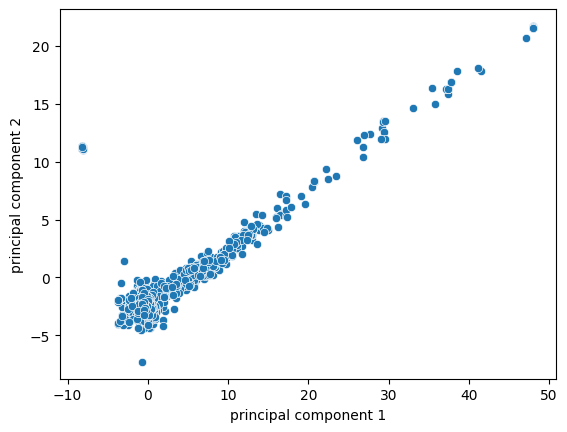

In [1452]:
sns.scatterplot(principal['principal component 1'], principal['principal component 2'])

Теперь обучаем PCA+KMeans

Применим elbow method:

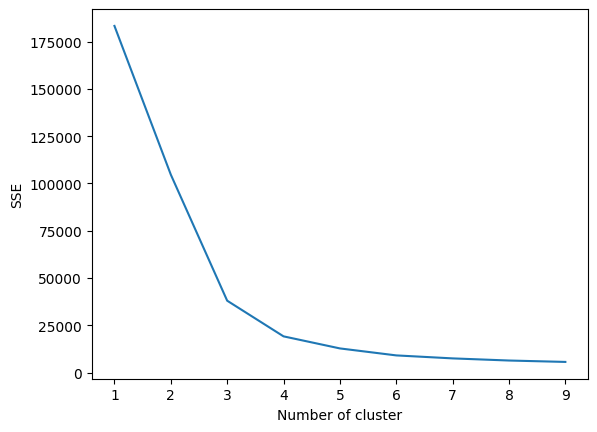

In [1453]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

data = principal

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    data["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

Выберем число кластеров 5 (по графику elbow method такое число тоже приемлемо, при этом при нем метрика лучше).

In [1475]:
kmeans = KMeans(n_clusters=5).fit(principal)
l = kmeans.labels_

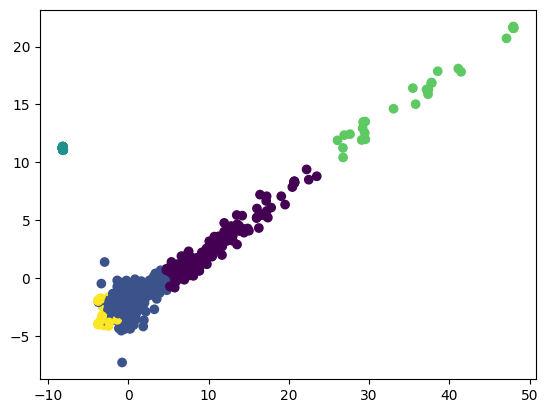

In [1476]:
plt.scatter(principal['principal component 1'], 
             principal['principal component 2'],
             c=l,
           )

Оценим качество с помощью [silhouette score](https://stephenallwright.com/good-clustering-metrics/):

In [1477]:
from sklearn import metrics
metrics.silhouette_score(principal,l)

0.8259594885688628

Теперь DBSCAN

0.7156154944230374

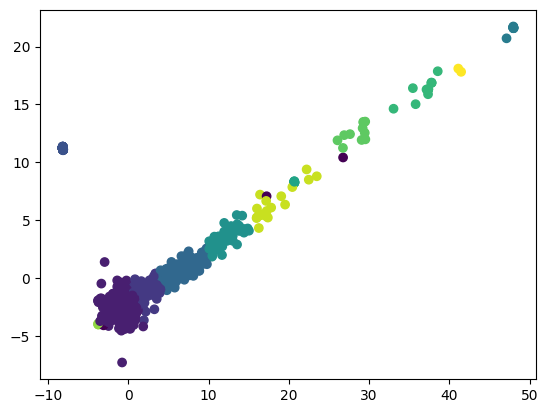

In [1457]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=3, min_samples=2).fit(principal)
clustering.labels_
plt.scatter(principal['principal component 1'], 
             principal['principal component 2'],
             c=clustering.labels_,
           )
metrics.silhouette_score(principal,clustering.labels_)

Теперь Гауссовская смесь.

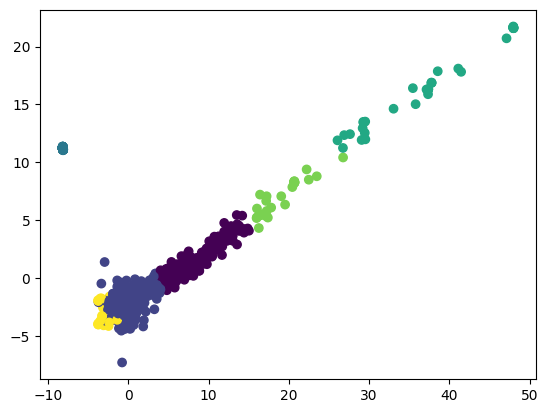

In [1470]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=6, random_state=0).fit(principal)
gm.predict(principal)
plt.scatter(principal['principal component 1'], 
             principal['principal component 2'],
             c=gm.predict(principal),
           )

Путем перебора я получил, что именно при 6 кластерах достигается максимум метрики:

In [1471]:
metrics.silhouette_score(principal,gm.predict(principal))

0.8115524179432096

Самым лучшим по метрике оказался KMeans. При этом график двумерной проекции выглядит наиболее адекватным нашим данным (кластеры выделены разумно).

In [1482]:
df['clust'] = l

In [1483]:
df.to_csv('resumes_features.csv')

**Анализ кластеров**

Самым лучшим оказался KMeans. Проанализируем наши данные, основываясь на его результатах.

In [3]:
df = pd.read_csv('resumes_features.csv')

In [4]:
df.drop(list(df)[0], axis=1, inplace=True)
df.reset_index(inplace=True)
df.drop(list(df)[0], axis=1, inplace=True)

In [5]:
df.sample(1)

,Ссылка,Название,Коммандировка,Опыт,О себе,Образование,Интересы,Навыки,Образование-1,Образование-2,...,93,94,95,96,97,98,99,clust,"DA, predicted","DS, predicted"
65,https://hh.ru/resume/4210911700043613eb0039ed1...,"Бухгалтер-аудитор, бухгалтер, экономист","Москва, не готов к переезду, готов к редким ко...",Опыт работы 7 месяцев,- Имеются сертификаты о публикациях научных ст...,Высшее образование\n2019\nГосударственный унив...,Специализации:\nБухгалтер\nЗанятость: полная з...,---,"Государственный университет управления, Москва","Государственный университет управления, Москва",...,-0.001127,-0.001426,-0.002135,-0.002997,0.000601,0.001671,-0.001503,1,0.0,0.0


Что за кластеры:

In [100]:
df.loc[df['clust']==0]['О себе']

22      ---
31      ---
33      ---
34      ---
46      ---
       ... 
2711    ---
2716    ---
2717    ---
2723    ---
2724    ---
Name: О себе, Length: 356, dtype: object

In [102]:
df.loc[df['clust']==1]['О себе']

0       Уверенный пользователь ПК, Ms Word, Ms Excel, ...
1       Энергична, активна, в поиске новых возможносте...
2       опыт прямых продаж, ведение коммерческих перег...
3       Коммуникабелен\nУмение работать с возражениями...
4       Дисциплина - умение выполнять поставленные зад...
                              ...                        
2714    Опыт управления более 15-и лет. Развитые управ...
2715    Аналитика продаж ,поиск клиентов,связь с произ...
2719    Многозадачность, стрессоустойчивость, инициати...
2720    Уверенный пользователь ПК: MS Office (Word, Ex...
2722                                                    .
Name: О себе, Length: 2156, dtype: object

In [103]:
df.loc[df['clust']==2]['О себе']

58      Общий стаж работы более 20 лет. Легко обучаюсь...
128     Легко и быстро обучаюсь, целеустремленная, вни...
298     Добрый день. Немного обо мне: Успешное провиде...
336     Аналитический склад ума, высокая концентрация,...
376     Пунктуальная, исполнительная, мобильная.\nУмею...
513     • Умею и люблю учиться;\n• Пунктуальна и дисци...
593     Работал с людьми обладаю управлять командой зн...
661     Люблю ответственность и ответственных людей, п...
759     Умею работать в режиме многозадачности, пункту...
891     Ответственная, целеустремленная, коммуникабель...
1020    Готова сразу приступить к работе.\n\nExcel- ув...
1140    Люблю думать, создавать, видеть в своей работе...
1298    Имею опыт работы в коллективе, организована, о...
1442    Здравствуйте, меня зовут Ксения.\nИз качеств о...
1493    Уравновешенный, целеустремленный, коммуникабел...
1530    Я люблю интересную работу с возможностями разв...
1556    Очень люблю автомобили, много читаю, в т.ч. те...
1595    Легко 

In [104]:
df.loc[df['clust']==3]['О себе']

29      Разбираюсь в новых системах и проектах, люблю ...
32      Имею большой опыт в продажах. Работая в любом ...
101     легко обучаема,целеустремленная,клиентоорентир...
109     - люблю много и результативно работать\n- ценю...
113     Ответственная, активная, быстро обучаюсь и усв...
                              ...                        
2701    Пользователь MS Office (Word, Excel, Internet)...
2706    ответственная, коммуникабельная, работаю в усл...
2708    Сильный бэкграунд, опыт работы в различных сфе...
2718    Коммуникабельный,инновационный.\nОбладаю спосо...
2721    Моя потребность в постоянном улучшении себя на...
Name: О себе, Length: 176, dtype: object

In [1481]:
df.loc[df['clust']==4]['О себе']

159     Увлечения: спорт, активный образ жизни.\nЛичны...
279     Интиллегентный, ответственный, целеустремлённы...
320     Способен решить в кратчайший срок все возникши...
321     Коммуникабельная, приятной наружности. Исполни...
411         Целеустремленный человек, с тягой познания...
486     Ответственный, стрессоустойчивый, креативный, ...
535     Ответственная, целеустремлённая, быстро схваты...
578     Ответственный, честный, усидчивый, стрессоусто...
618     Стремление к самообразованию. Требовательность...
623     Активная, увлекаюсь интеллектуальными играми, ...
624     Коммуникабелен, ответственен, настойчив в дост...
647     Аналитический, креативный склад ума, работоспо...
677                        Целеустремленная,пунктуальная.
707     туризм, спортивная рыбалка, книги, бадминтон.\...
717     Семейное положение: женат. дочь 9 лет.\nВодите...
754     Хоби, спорт, туризм, активный отдых, рыбалка о...
780     Аналитический склад ума, целеустремленный, раб...
817     личнос

In [1480]:
for x in np.unique(df['clust']):
    print(x + 1, ':', df.loc[df['clust']==x]['О себе'].shape[0])

1 : 191
2 : 2101
3 : 356
4 : 37
5 : 40
